In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!cp  "/content/drive/My Drive/Academics/CS/AML/Project/Data/preprocessed_full.csv" .

In [3]:
import pandas as pd
import numpy as np
import math
import random

In [4]:
data_full = pd.read_csv("preprocessed_full.csv")
#concert to string from object
data_full["Text"]= data_full["Text"].astype("str")
data_full["IsHate"] = data_full["IsHate"].astype("int")
data_full.shape

(47652, 2)

### Install TensorFlow and TensorFlow Model Garden

In [5]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [6]:
!pip install -q tensorflow==2.3.0

In [7]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2319/2319), done.
remote: Total 2650 (delta 511), reused 1351 (delta 298), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (511/511), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [8]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 215kB 7.4MB/s 
     |████████████████████████████████| 14.5MB 246kB/s 
     |████████████████████████████████| 471kB 72.7MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 25.9MB 124kB/s 
     |████████████████████████████████| 174kB 69.6MB/s 
     |████████████████████████████████| 3.6MB 22.6MB/s 
     |████████████████████████████████| 1.1MB 55.6MB/s 
     |████████████████████████████████| 358kB 81.3MB/s 
     |████████████████████████████████| 1.1MB 68.9MB/s 
     |████████████████████████████████| 11.6MB 71kB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
     |████████████████████████████████| 276kB 68.7MB/s 
     |████████████████████████████████| 2.2MB 50.0MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
ER

In [9]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [10]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


### Model logistics
<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [11]:
!pip install matplotlib==3.1.3
!pip install scipy==1.4.1
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_df, remaining = train_test_split(data_full, random_state=42, train_size=0.85, stratify=data_full.IsHate.values)
train_df, valid_df = train_test_split(train_df, random_state=42, train_size=0.8, stratify=train_df.IsHate.values)
train_df.shape, valid_df.shape

     |████████████████████████████████| 13.1MB 252kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3


     |████████████████████████████████| 26.1MB 123kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4


((32403, 2), (8101, 2))

###  Create tf.data.Datasets for Training and Evaluation

In [33]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.Text.values, train_df.IsHate.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.Text.values, valid_df.IsHate.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'thathaleyway kdawgg065 aahahah fuck watch trash', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [34]:
train_data

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

### Download a Pre-trained BERT Model from TensorFlow Hub

In [35]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [36]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [37]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

### Tokenize and Preprocess Text for BERT

In [38]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  # print(max_seq_length)
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

### Wrap a Python Function into a TensorFlow op for Eager Execution

In [39]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [40]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

In [21]:
# data spec


In [22]:
# data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [23]:
print(max_seq_length)

128


### Add a Classification Head to the BERT Layer

In [41]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

### Fine-Tune BERT for Text Classification

In [42]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [43]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[F1_Score()])
# tf.keras.metrics.BinaryAccuracy()
# 2 * (precision * recall) / (precision + recall)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

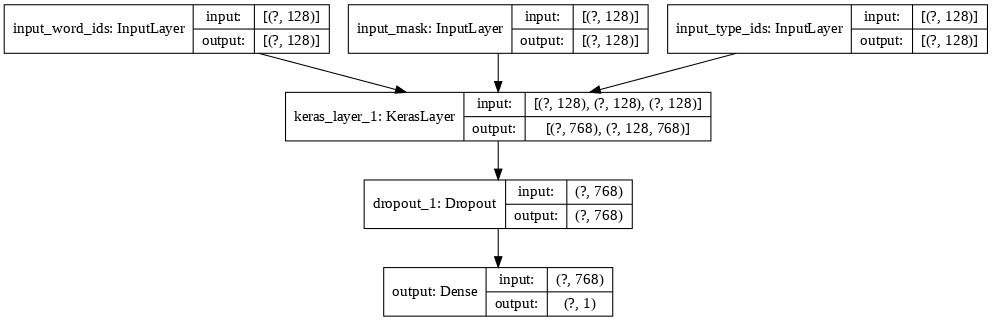

In [44]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [ ]:
# Train model
epochs = 150
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/150
1012/1012 [==============================] - 509s 503ms/step - loss: 0.2876 - f1_score: 0.8868 - val_loss: 0.2177 - val_f1_score: 0.9195
Epoch 2/150
1012/1012 [==============================] - 508s 502ms/step - loss: 0.1891 - f1_score: 0.9314 - val_loss: 0.2250 - val_f1_score: 0.9250
Epoch 3/150
1012/1012 [==============================] - 508s 502ms/step - loss: 0.1314 - f1_score: 0.9548 - val_loss: 0.2746 - val_f1_score: 0.9240
Epoch 4/150
1012/1012 [==============================] - 508s 502ms/step - loss: 0.0827 - f1_score: 0.9738 - val_loss: 0.3219 - val_f1_score: 0.9236
Epoch 5/150
1012/1012 [==============================] - 508s 502ms/step - loss: 0.0570 - f1_score: 0.9826 - val_loss: 0.3625 - val_f1_score: 0.9229
Epoch 6/150
1012/1012 [==============================] - 508s 502ms/step - loss: 0.0388 - f1_score: 0.9883 - val_loss: 0.3791 - val_f1_score: 0.9235
Epoch 7/150
1012/1012 [==============================] - 508s 501ms/step - loss: 0.0323 - f1_score: 0.9904

## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

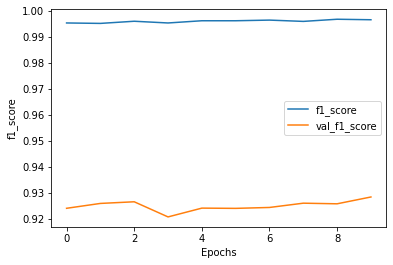

In [ ]:
plot_graphs(history, 'f1_score')

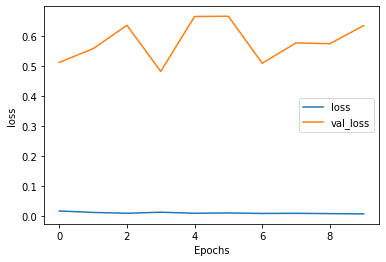

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
model.evaluate(valid_data, verbose=1)

253/253 [==============================] - 39s 155ms/step - loss: 0.6342 - f1_score: 0.9284


[0.6342049241065979, 0.9283972382545471]

In [ ]:
preds